# Introduction
This kernel has been created by the [Information Systems Lab](http://islab.uom.gr) to introduce students of the [University of Macedonia](http://www.uom.gr/index.php?tmima=2&categorymenu=2), Greece to Machine Learning & Data Science.

## The Instacart competition
Instacart is an American company that operates as a same-day grocery delivery service. Customers select groceries through a web application from various retailers and delivered by a personal shopper. Instacart's service is mainly provided through a smartphone app, available on iOS and Android platforms, apart from its website.

In 2017 Instacart organised a Kaggle competition and provided to the community a sample dataset of over 3 million grocery orders from more than 200,000 Instacart users. The orders include 32 million basket items and 50,000 unique products. The objective of the competition was participants to **predict which previously purchased products will be in a user’s next order**.

## Objective
The objective of this Kernel is to introduce students to predictive business analytics with Python through the Instacart case. 

By the time you finish this example, you will be able to:
* Describe the steps of creating a predictive analytics model
* Use Python and Pandas package to manipulate data
* Use Python and Pandas package to create, combine, and delete DataFrames
* Use Random Forests to create a predictive model
* Apply the predictive model in order to make a prediction
* Create a submission file for the competition of Instacart

## Problem definition
The data that Instacart opened up include orders of 200,000 Instacart users with each user having between 4 and 100 orders. Instacart indicates each order in the data as prior, train or test. Prior orders describe the **past behaviour** of a user while train and test orders regard the **future behaviour that we need to predict**. 

As a result, we want to predict which previously purchased products (prior orders) will be in a user’s next order (train and test orders). 

For the train orders Instacart reveals the results (i.e., the ordered products) while for the test orders we do not have this piece of information. Moreover, the future order of each user can be either train or test meaning that each user will be either a train or a test user. 

The setting of the Instacart problem is described in the figure below (orders with yellow color denotes future orders of a user). 

<img src="https://i.imgur.com/S0Miw3m.png" width="350">

Each user has purchased various products during their prior orders. Moreover, for each user we know the order_id of their future order. The goal is to predict which of these products will be in a user's future order. 

This is a **classification problem** because we need to predict whether each pair of user and product is a reorder or not. This is indicated by the value of the reordered variable, i.e. reordered=1 or reordered=0 (see figure below). 

<img src="https://i.imgur.com/SxK2gsR.png" width="350">

As a result we need to come up and calculate various **predictor variables (X)** that will describe the characteristics of a product and the behaviour of a user regarding one or multiple products. We will do so by analysing the prior orders of the dataset. We will then use the train users to create a predictive model and the test users to make our actual prediction. As a result we create a table as the following one and we train an algorithm based on predictor variables (X) and response variable (Y).

<img src="https://i.imgur.com/Yb1CKAF.png" width="600">

## Method
Our method includes the following steps:
1. <b>Import and reshape data</b>: This step includes loading CSV files into pandas DataFrames, tranform character variables to categorical variables, and create a supportive table.
2. <b>Create predictor variables</b>: This step includes identifying and calculating predictor variables (aka features) from the initial datasets provided by Instacart. 
3. <b>Create train and test DataFrames</b>: In this step we create two distinct pandas DataFrames that will be used in the creation and the use of the predictive model.
4. <b>Create predictive model (fit)</b>: In this step we train a predictive model through the train dataset.
5. <b>Apply predictive model (predict)</b>: This step includes applying the model to predict the 'reordered' variable for the test dataset.
6. <b>Create submission file</b>: In this final step we create the submission file with our predictions for Instacart's competition.
7. <b>Get F1 score</b>: In this step we submit the produced and file and get the F1 score describing the accuracy of our prediction model.

# 1. Import and Reshape Data 
First we load the necessary Python packages and then we import the CSV files that were provided by Instacart.

## 1.1 Import the required packages
The garbage collector (package gc), attempts to reclaim garbage, or memory occupied by objects (e.g., DataFrames) that are no longer in use by Python ([ref1](https://www.techopedia.com/definition/1083/garbage-collection-gc-general-programming), [ref2](https://en.wikipedia.org/wiki/Garbage_collection_(computer_science)). This package will eliminate our risk to exceed the 16GB threshold of available RAM that Kaggle offers.

The **"as"** reserved word is to define an alias to the package. The alias help us to call easier a package in our code.

In [1]:
# For data manipulation
import pandas as pd         

# Garbage Collector to free up memory
import gc                         
gc.enable()                       # Activate 

## 1.2 Load data from the CSV files
Instacart provides 6 CSV files, which we have to load into Python. Towards this end, we use the .read_csv() function, which is included in the Pandas package. Reading in data with the .read_csv( ) function returns a DataFrame.

First we connect to the Kaggle API in order to download the zip file with the 6 CSVs. Then we unzip it in a new folder named input, and we unzip all the zip files.

In [ ]:
#This is for Google Colab
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# connect to kaggle api and download files (zip)
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi({"username":"evangeloskalampokis","key":"227307bd0d825ea8f784cb00dc373357"})
api.authenticate()
files = api.competition_download_files("Instacart-Market-Basket-Analysis")

In [ ]:
import zipfile
with zipfile.ZipFile('Instacart-Market-Basket-Analysis.zip', 'r') as zip_ref:
    zip_ref.extractall('./input')

In [ ]:
import os
working_directory = os.getcwd()+'/input'
os.chdir(working_directory)
for file in os.listdir(working_directory):   # get the list of files
    if zipfile.is_zipfile(file): # if it is a zipfile, extract it
        with zipfile.ZipFile(file) as item: # treat the file as a zip
           item.extractall()  # extract it in the working directory

In [2]:
orders = pd.read_csv('../input/orders.csv' )
order_products_train = pd.read_csv('../input/order_products__train.csv')
order_products_prior = pd.read_csv('../input/order_products__prior.csv')
products = pd.read_csv('../input/products.csv')
aisles = pd.read_csv('../input/aisles.csv')
departments = pd.read_csv('../input/departments.csv')

This step results in the following DataFrames:
* <b>orders</b>: This table includes all orders, namely prior, train, and test. It has single primary key (<b>order_id</b>).
* <b>order_products_train</b>: This table includes training orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>order_products_prior </b>: This table includes prior orders. It has a composite primary key (<b>order_id and product_id</b>) and indicates whether a product in an order is a reorder or not (through the reordered variable).
* <b>products</b>: This table includes all products. It has a single primary key (<b>product_id</b>)
* <b>aisles</b>: This table includes all aisles. It has a single primary key (<b>aisle_id</b>)
* <b>departments</b>: This table includes all departments. It has a single primary key (<b>department_id</b>)

If you want to reduce the execution time of this Kernel you can use the following piece of code by uncomment it. This will trim the orders DataFrame and will keep a 10% random sample of the users. You can use this for experimentation.

In [3]:

#### Remove triple quotes to trim your dataset and experiment with your data
### COMMANDS FOR CODING TESTING - Get 10% of users 
###orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 


We now use the .head( ) method in order to visualise the first 10 rows of these tables. Click the Output button below to see the tables.

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
54,2565571,7,prior,1,3,9,NaN
55,2402008,7,prior,2,1,19,30.0
56,121053,7,prior,3,0,18,30.0
57,1695742,7,prior,4,2,10,9.0
58,3321109,7,prior,5,5,18,3.0


In [5]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [6]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [7]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## 1.3 Reshape data
We transform the data in order to facilitate their further analysis. First, we convert character variables into categories so we can use them in the creation of the model. In Python, a categorical variable is called category and has a fixed number of different values.

In [10]:
# We convert character variables into category. 
# In Python, a categorical variable is called category and has a fixed number of different values
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

## 1.4 Create a DataFrame with the orders and the products that have been purchased on prior orders (op)
We create a new DataFrame, named <b>op</b> which combines (merges) the DataFrames <b>orders</b> and <b>order_products_prior</b>. Bear in mind that <b>order_products_prior</b> DataFrame includes only prior orders, so the new DataFrame <b>op</b>  will contain only these observations as well. Towards this end, we use pandas' merge function with how='inner' argument, which returns records that have matching values in both DataFrames. 
<img src="https://i.imgur.com/zEK7FpY.jpg" width="400">

In [11]:
#Merge the orders DF with order_products_prior by their order_id, keep only these rows with order_id that they are appear on both DFs
op = orders.merge(order_products_prior, on='order_id', how='inner')
op.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2565571,7,prior,1,3,9,NaN,45628,1,0
1,2565571,7,prior,1,3,9,NaN,39275,2,0
2,2565571,7,prior,1,3,9,NaN,6361,3,0
3,2565571,7,prior,1,3,9,NaN,45066,4,0
4,2565571,7,prior,1,3,9,NaN,13249,5,0


The table contains for all the customers **(user_id)**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the orders **(order_id)** that they have placed accompanied with: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ➡︎ the products **(product_id)** that have been bought in each order

# 2. Create Predictor Variables
We are now ready to identify and calculate predictor variables based on the provided data. We can create various types of predictors such as:
* <b>User predictors</b> describing the behavior of a user e.g. total number of orders of a user.
* <b>Product predictors</b> describing characteristics of a product e.g. total number of times a product has been purchased.
* <b>User & product predictors</b> describing the behavior of a user towards a specific product e.g. total times a user ordered a specific product.

## 2.1 Create user predictors
We create the following predictors:
- 2.1.1 Number of orders per customer
- 2.1.2 How frequent a customer has reordered products

### 2.1.1 Number of orders per customer
We calculate the total number of placed orders per customer. We create a **user** DataFrame to store the results.

In [12]:
## First approach in one step:
# Create distinct groups for each user, identify the highest order number in each group, save the new column to a DataFrame
user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
user.head()

## Second approach in two steps: 
#1. Save the result as DataFrame with Double brackets --> [[ ]] 
#user = op.groupby('user_id')[['order_number']].max()
#2. Rename the label of the column
#user.columns = ['u_total_orders']
#user.head()

,u_total_orders
user_id,
7,20
14,13
22,15
24,18
29,18


In [13]:
# Reset the index of the DF so to bring user_id from index to column (pre-requisite for step 2.4)
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,7,20
1,14,13
2,22,15
3,24,18
4,29,18


### 2.1.2 How frequent a customer has reordered products

This feature is a ratio which shows for each user in what extent has products that have been reordered in the past: <br>
So we create the following ratio: <br>

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id)=&space;\frac{total\&space;times\&space;of\&space;reorders}{total\&space;number\&space;of\&space;purchased\&space;products\&space;from\&space;all\&space;baskets}" title="probability\ reordered\ (user\_id)= \frac{total\ times\ of\ reorders}{total\ number\ of\ purchased\ products\ from\ all\ baskets}" />

The nominator is a counter for all the times a user has reordered products (value on reordered=1), the denominator is a counter of all the products that have been purchased on all user's orders (reordered=0 & reordered=1).

E.g., for a user that has ordered 6 products in total, where 3 times were reorders, the ratio will be:

![example ratio](https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;&space;mean=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1}{6}&space;=&space;0,5) 

To create the above ratio we .groupby() order_products_prior by each user and then calculate the mean of reordered.


In [14]:
u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
u_reorder.head()

,user_id,u_reordered_ratio
0,7,0.669903
1,14,0.323810
2,22,0.507246
3,24,0.526316
4,29,0.702222


The new feature will be merged with the user DataFrame (section 2.1.1) which keep all the features based on users. We perform a left join as we want to keep all the users that we have created on the user DataFrame

<img src="https://i.imgur.com/wMmC4hb.jpg" width="400">

In [15]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

user.head()

,user_id,u_total_orders,u_reordered_ratio
0,7,20,0.669903
1,14,13,0.323810
2,22,15,0.507246
3,24,18,0.526316
4,29,18,0.702222


## 2.2 Create product predictors
We create the following predictors:
- 2.2.1 Number of purchases for each product
- 2.2.2 What is the probability for a product to be reordered

### 2.2.1 Number of purchases for each product
We calculate the total number of purchases for each product (from all customers). We create a **prd** DataFrame to store the results.

In [16]:
# Create distinct groups for each product, count the orders, save the result for each product to a new DataFrame  
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd.head()

,p_total_purchases
product_id,
1,205
2,13
3,15
4,37
6,1


In [17]:
# Reset the index of the DF so to bring product_id rom index to column (pre-requisite for step 2.4)
prd = prd.reset_index()
prd.head()

,product_id,p_total_purchases
0,1,205
1,2,13
2,3,15
3,4,37
4,6,1


## 2.2.2 What is the probability for a product to be reordered
In this section we want to find the products which have the highest probability of being reordered. Towards this end it is necessary to define the probability as below:
<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;probability\&space;reordered\&space;(product\_id)=&space;\frac{number\&space;of\&space;reorders}{total\&space;number\&space;of\&space;orders\&space;}" title="probability\ reordered\ (product\_id)= \frac{number\ of\ reorders}{total\ number\ of\ orders\ }" />

Example: The product with product_id=2 is included in 90 purchases but only 12 are reorders. So we have:  

<img src="https://latex.codecogs.com/gif.latex?\dpi{150}&space;\large&space;p\_reorder\(product\_id\mathop{==}&space;2&space;)=&space;\frac{12}{90}=&space;0,133" title="\large p\_reorder\(product\_id\mathop{==} 2 )= \frac{12}{90}= 0,133" />

### 2.2.2.1 Remove products with less than 40 purchases - Filter with .shape[0]
Before we proceed to this estimation, we remove all these products that have less than 40 purchases in order the calculation of the aforementioned ratio to be meaningful.

Using .groupby() we create groups for each product and using .filter( ) we keep only groups with more than 40 rows. Towards this end, we indicate a lambda function.

In [18]:
# execution time: 25 sec
# the x on lambda function is a temporary variable which represents each group
# shape[0] on a DataFrame returns the number of rows
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >40)
p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
1,2565571,7,prior,1,3,9,NaN,39275,2,0
2,2565571,7,prior,1,3,9,NaN,6361,3,0
3,2565571,7,prior,1,3,9,NaN,45066,4,0
4,2565571,7,prior,1,3,9,NaN,13249,5,0
5,2565571,7,prior,1,3,9,NaN,31683,6,0


### 2.2.2.2 Group products, calculate the mean of reorders

To calculate the reorder probability we will use the aggregation function mean() to the reordered column. In the reorder data frame, the reordered column indicates that a product has been reordered when the value is 1.

The .mean() calculates how many times a product has been reordered, divided by how many times has been ordered in total. 

E.g., for a product that has been ordered 9 times in total, where 4 times has been reordered, the ratio will be:

![example ratio](https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;&space;mean=&space;\frac{0&plus;1&plus;0&plus;0&plus;1&plus;1&plus;0&plus;0&plus;1}{9}&space;=&space;0,44) 

We calculate the ratio for each product. The aggregation function is limited to column 'reordered' and it calculates the mean value of each group.

In [19]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.692683
1,10,0.535849
2,23,0.446809
3,25,0.707819
4,28,0.534247


### 2.2.2.3 Merge the new feature on prd DataFrame
The new feature will be merged with the prd DataFrame (section 2.2.1) which keep all the features based on products. We perform a left join as we want to keep all the products that we have created on the prd DataFrame
<img src="https://i.imgur.com/dOVWPKb.jpg" width="400">

In [20]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,205,0.692683
1,2,13,NaN
2,3,15,NaN
3,4,37,NaN
4,6,1,NaN


#### 2.2.2.4 Fill NaN values
As you may notice, there are product with NaN values. This regards the products that have been purchased less than 40 times from all users and were not included in the p_reorder DataFrame. **As we performed a left join with prd DataFrame, all the rows with products that had less than 40 purchases from all users, will get a NaN value.**

For these products we their NaN value with zero (0):

In [21]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,205,0.692683
1,2,13,0.000000
2,3,15,0.000000
3,4,37,0.000000
4,6,1,0.000000


> Our final DataFrame should not have any NaN values, otherwise the fitting process (chapter 4) will throw an error!

## 2.3 Create user-product predictors
We create the following predictors:
- 2.3.1 How many times a user bought a product
- 2.3.2 How frequently a customer bought a product after its first purchase
- 2.3.3 How many times a customer bought a product on its last 5 orders

### 2.3.1 How many times a user bought a product
We create different groups that contain all the rows for each combination of user and product. With the aggregation function .count( ) we get how many times each user bought a product. We save the results on new **uxp** DataFrame.

In [22]:
# Create distinct groups for each combination of user and product, count orders, save the result for each user X product to a new DataFrame 
uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
7       274                        1
        519                        2
        4920                       7
        4945                       3
        6361                       5

In [23]:
# Reset the index of the DF so to bring user_id & product_id rom indices to columns (pre-requisite for step 2.4)
uxp = uxp.reset_index()
uxp.head()

,user_id,product_id,uxp_total_bought
0,7,274,1
1,7,519,2
2,7,4920,7
3,7,4945,3
4,7,6361,5


### 2.3.2 How frequently a customer bought a product after its first purchase
This ratio is a metric that describes how many times a user bought a product out of how many times she had the chance to a buy it (starting from her first purchase of the product):

<img src="https://latex.codecogs.com/gif.latex?\dpi{120}&space;\large&space;probability\&space;reordered\&space;(user\_id\&space;,&space;product\_id)&space;=&space;\frac{Times\_Bought\_N}{Order\_Range\_D}" title="\large probability\ reordered\ (user\_id\ , product\_id) = \frac{Times\_Bought\_N}{Order\_Range\_D}" />

* Times_Bought_N = Times a user bought a product
* Order_Range_D = Total orders placed since the first user's order of a product

To clarify this, we examine the use with user_id:1 and the product with product_id:13032. User 1 has made 10 orders in total.She has bought the product 13032 **for first time in her 2nd order** and she has bought the same product 3 times in total. The user was able to buy the product 9 times (starting from her 2nd order until her last order). As a result, she has bought it 3 out of 9 times, meaning reorder_ratio=3/9= 0,333.

The Order_Range_D variable is created using two supportive variables:
* Total_orders = Total number of orders of each user
* First_order_number = The order number where the customer bought a product for first time

In the next blocks we show how we create:
1. The numerator 'Times_Bought_N'
2. The denumerator 'Order_Range_D' with the use of the supportive variables 'total_orders' & 'first_order_number' 
3. Our final ratio 'uxp_order_ratio'

### 2.3.2.1 Calculate the numerator ('Times_Bought_N')

To answer this question we simply .groupby( ) user_id & product_id and we count the instances of order_id for each group.

In [24]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
7       274                      1
        519                      2
        4920                     7
        4945                     3
        6361                     5

### 2.3.2.2 Calculate the denumerator ('Order_Range_D')
To calculate the denumerator, we first calculate the total orders of each user & first order number for each user and every product purchase.

In order to calculate the total number of orders of each cutomer ('total_orders') we .groupby( ) only by the user_id, we keep the column order_number and we get its highest value with the aggregation function .mean()

In [25]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders.head()

,total_orders
user_id,
7,20
14,13
22,15
24,18
29,18


In order to calculate the order number where the user bought a product for first time ('first_order_number') we .groupby( ) by both user_id & product_id and we select the order_number column and we retrieve the .min( ) value.

In [26]:
first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no.head()

,user_id,product_id,first_order_number
0,7,274,2
1,7,519,1
2,7,4920,2
3,7,4945,16
4,7,6361,1


We merge the first order number with the total_orders DataFrame. As total_orders refers to all users, where first_order_no refers to unique combinations of user & product, we perform a right join:
<img src="https://i.imgur.com/bhln0tn.jpg" width="250">

In [27]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span.head()

,user_id,total_orders,product_id,first_order_number
0,7,20,274,2
1,7,20,519,1
2,7,20,4920,2
3,7,20,4945,16
4,7,20,6361,1


The denominator ('Order_Range_D') now can be created with simple operations between the columns of span DataFrame:

In [28]:
# The +1 includes in the difference the first order were the product has been purchased
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span.head()

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,7,20,274,2,19
1,7,20,519,1,20
2,7,20,4920,2,19
3,7,20,4945,16,5
4,7,20,6361,1,20


### 2.3.2.3 Create the final ratio "uxp_reorder_ratio"

We merge **times** DataFrame, which contains the numerator, and **span** DataFrame, which contains the denumerator of our desired ratio. **As both variables derived from the combination of users & products, any type of join will keep all the combinations.**

<img src="https://i.imgur.com/h7m1bFh.jpg" width="250">

In [29]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,7,274,1,20,2,19
1,7,519,2,20,1,20
2,7,4920,7,20,2,19
3,7,4945,3,20,16,5
4,7,6361,5,20,1,20



We divide the Times_Bought_N by the Order_Range_D for each user and product.

In [30]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,7,274,1,20,2,19,0.052632
1,7,519,2,20,1,20,0.100000
2,7,4920,7,20,2,19,0.368421
3,7,4945,3,20,16,5,0.600000
4,7,6361,5,20,1,20,0.250000



We select to keep only the 'user_id', 'product_id' and the final feature 'uxp_reorder_ratio'


In [31]:
uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio.head()

,user_id,product_id,uxp_reorder_ratio
0,7,274,0.052632
1,7,519,0.100000
2,7,4920,0.368421
3,7,4945,0.600000
4,7,6361,0.250000


In [32]:
#Remove temporary DataFrames
del [times, first_order_no, span]

### 2.3.2.4 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

<img src="https://i.imgur.com/hPJXBuB.jpg" width="250">

In [33]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,7,274,1,0.052632
1,7,519,2,0.100000
2,7,4920,7,0.368421
3,7,4945,3,0.600000
4,7,6361,5,0.250000


### 2.3.3 How many times a customer bought a product on its last 5 orders
For this feature, we want to keep the last five orders for each customer and get how many times bought any product on them. To achieve this we need to:
* Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
* Keep only the last five orders for each order
* Perform a .groupby( ) on users and products to get how many times each customer bought a product.
* Create the following ratio:

![](https://latex.codecogs.com/gif.latex?times%5C%20last%20%5C5%5C%20%28of%5C%20a%5C%20purchased%5C%20product%5C%20from%5C%20a%5C%20user%29%3D%5Cfrac%7BTimes%5C%20a%5C%20user%5C%20bought%5C%20a%5C%20product%5C%20on%5C%20its%5C%20last%5C%205%5C%20orders%7D%7BTotal%5C%20orders%5C%20%3D5%7D)

#### 2.3.3.1 Create a new variable ('order_number_back') which keeps the order_number for each order in reverse order
In this step we show how we create a reverse order_number for each customer. <br>
Have a look at the orders of customer 1 (user_id == 1)

In [34]:
op[op.user_id==1].head(45)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered


Our goal is a to create a new column ('order_number_back') which indicates the last order as first, the second from the end as second and so on. To achieve this, we get the highest order_number (max) for user_id==1 and we subtract the order_number of each order from it. Thus for last order (order_number == 10) that will be: 
<br>
<br>

![order_number_back](https://latex.codecogs.com/png.latex?%5Cdpi%7B200%7D%20%5Ctiny%20%5Cfontsize%7B%20%7D%7Bbaselineskip%7D%20order%5C_number%5C_back%28x%29%3D%20order%5C_number.max%28%29%20-order%5C_number%28x%29%3D10%20-%2010%20%3D%200)

And as we want the last order to be marked as first, rather than zeroth, the previous formula will be:

![](https://latex.codecogs.com/png.latex?%5Cdpi%7B200%7D%20%5Ctiny%20%5Cfontsize%7B%20%7D%7Bbaselineskip%7D%20order%5C_number%5C_back%28x%29%3D%20order%5C_number.max%28%29%20-order%5C_number%28x%29%3D10%20-%2010%20&plus;1%3D%201)

> Note that order_number.max( ) is a single value, where order_number is a 1-D array (column/Series)

By applying the above formula to the orders of user_id == 1 we get the following results:
![](https://i.imgur.com/toda8ay.png)

In the next code block we perform the same calculations for all users. We .groupby( ) op by the user_id and we select the column order_number. With .transform(max) we request to get the highest number of the column order_number for each group & with minus (-) op.order_number we substract the order_number of each row. Finally we add 1 for the reason mentioned above.

> .transform( ) perform some group-specific computations and return a like-indexed object. 

In [35]:
op['order_number_back'] = op.groupby('user_id')['order_number'].transform(max) - op.order_number +1 
op.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2565571,7,prior,1,3,9,NaN,45628,1,0,20
1,2565571,7,prior,1,3,9,NaN,39275,2,0,20
2,2565571,7,prior,1,3,9,NaN,6361,3,0,20
3,2565571,7,prior,1,3,9,NaN,45066,4,0,20
4,2565571,7,prior,1,3,9,NaN,13249,5,0,20
5,2565571,7,prior,1,3,9,NaN,31683,6,0,20
6,2565571,7,prior,1,3,9,NaN,519,7,0,20
7,2565571,7,prior,1,3,9,NaN,37999,8,0,20
8,2565571,7,prior,1,3,9,NaN,49508,9,0,20
9,2565571,7,prior,1,3,9,NaN,29871,10,0,20


Check that the formula has been applied to all users. Here we check the new column for a random user (user_id== 7):

In [36]:
op[op.user_id==7].head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
0,2565571,7,prior,1,3,9,NaN,45628,1,0,20
1,2565571,7,prior,1,3,9,NaN,39275,2,0,20
2,2565571,7,prior,1,3,9,NaN,6361,3,0,20
3,2565571,7,prior,1,3,9,NaN,45066,4,0,20
4,2565571,7,prior,1,3,9,NaN,13249,5,0,20
5,2565571,7,prior,1,3,9,NaN,31683,6,0,20
6,2565571,7,prior,1,3,9,NaN,519,7,0,20
7,2565571,7,prior,1,3,9,NaN,37999,8,0,20
8,2565571,7,prior,1,3,9,NaN,49508,9,0,20
9,2565571,7,prior,1,3,9,NaN,29871,10,0,20


#### 2.3.3.2 Keep only the last five orders for each customer
With the use of order_number_back we can now select to keep only the last five orders of each customer:

In [37]:
op5 = op[op.order_number_back <= 5]
op5.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_back
148,2425840,7,prior,16,0,13,11.0,37602,1,1,5
149,2425840,7,prior,16,0,13,11.0,40852,2,1,5
150,2425840,7,prior,16,0,13,11.0,21137,3,1,5
151,2425840,7,prior,16,0,13,11.0,17638,4,1,5
152,2425840,7,prior,16,0,13,11.0,42265,5,0,5
153,2425840,7,prior,16,0,13,11.0,22000,6,0,5
154,2425840,7,prior,16,0,13,11.0,35333,7,0,5
155,2425840,7,prior,16,0,13,11.0,10504,8,0,5
156,2425840,7,prior,16,0,13,11.0,45066,9,1,5
157,2425840,7,prior,16,0,13,11.0,4920,10,1,5


#### 2.3.3.3 Perform a .groupby( ) on users and products to get how many times each customer bought every product.
Having kept the last 5 orders for each user, we perform a .groupby( ) on user_id & product_id. With .count( ) we get how many times each customer bought a product.

In [38]:
last_five = op5.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['times_last5']
last_five.head(10)

times_last5
user_id product_id             
7       4920                  2
        4945                  3
        8277                  1
        8518                  1
        9598                  1
        10504                 1
        11520                 1
        12196                 2
        13198                 2
        15592                 2

So for user_id==1, the product 196 has been ordered on all of its last five orders, where the product 35951 has been ordered only one time.

#### 2.3.3.5 Merge the final feature with uxp DataFrame
The new feature will be merged with the uxp DataFrame (section 2.3.1) which keep all the features based on combinations of user-products. We perform a left join as we want to keep all the user-products that we have created on the uxp DataFrame

<img src="https://i.imgur.com/ObfHDPl.jpg" width="400">

In [39]:
uxp = uxp.merge(last_five, on=['user_id', 'product_id'], how='left')

del [op5 , last_five]
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5
0,7,274,1,0.052632,NaN
1,7,519,2,0.100000,NaN
2,7,4920,7,0.368421,2.0
3,7,4945,3,0.600000,3.0
4,7,6361,5,0.250000,NaN


#### 2.3.3.6 Fill NaN values
If you check uxp DataFrame you will notice that some rows have NaN values for our new feature. This happens as there might be products that the customer did not buy on its last five orders. For these cases, we turn NaN values into zero (0) with .fillna(0) method.

In [40]:
uxp = uxp.fillna(0)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5
0,7,274,1,0.052632,0.0
1,7,519,2,0.100000,0.0
2,7,4920,7,0.368421,2.0
3,7,4945,3,0.600000,3.0
4,7,6361,5,0.250000,0.0


## 2.4 Merge all features
We now merge the DataFrames with the three types of predictors that we have created (i.e., for the users, the products and the combinations of users and products).

We will start from the **uxp** DataFrame and we will add the user and prd DataFrames. We do so because we want our final DataFrame (which will be called **data**) to have the following structure: 

<img style="float: left;" src="https://i.imgur.com/mI5BbFE.jpg" >






### 2.4.1 Merge uxp with user DataFrame
Here we select to perform a left join of uxp with user DataFrame based on matching key "user_id"

<img src="https://i.imgur.com/WlI84Ud.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the uxp (combination of user and products) DataFrame 
- all the **matching** observations of user DataFrame with uxp based on matching key **"user_id"**

The new DataFrame as we have already mentioned, will be called **data**.

In [41]:
#Merge uxp features with the user features
#Store the results on a new DataFrame
data = uxp.merge(user, on='user_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio
0,7,274,1,0.052632,0.0,20,0.669903
1,7,519,2,0.100000,0.0,20,0.669903
2,7,4920,7,0.368421,2.0,20,0.669903
3,7,4945,3,0.600000,3.0,20,0.669903
4,7,6361,5,0.250000,0.0,20,0.669903


### 2.4.1 Merge data with prd DataFrame
In this step we continue with our new DataFrame **data** and we perform a left join with prd DataFrame. The matching key here is the "product_id".
<img src="https://i.imgur.com/Iak6nIz.jpg" width="400">

Left join, ensures that the new DataFrame will have:
- all the observations of the data (features of userXproducts and users) DataFrame 
- all the **matching** observations of prd DataFrame with data based on matching key **"product_id"**

In [42]:
#Merge uxp & user features (the new DataFrame) with prd features
data = data.merge(prd, on='product_id', how='left')
data.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,7,274,1,0.052632,0.0,20,0.669903,232,0.301724
1,7,519,2,0.100000,0.0,20,0.669903,111,0.657658
2,7,4920,7,0.368421,2.0,20,0.669903,8126,0.666010
3,7,4945,3,0.600000,3.0,20,0.669903,599,0.732888
4,7,6361,5,0.250000,0.0,20,0.669903,333,0.756757


### 2.4.2 Delete previous DataFrames

The information from the DataFrames that we have created to store our features (op, user, prd, uxp) is now stored on **data**. 

As we won't use them anymore, we now delete them.

In [43]:
del op, user, prd, uxp
gc.collect()

95

# 3. Create train and test DataFrames
## 3.1 Include information about the last order of each user

The **data** DataFrame that we have created on the previous chapter (2.4) should include two more columns which define the type of user (train or test) and the order_id of the future order.
This information can be found on the initial orders DataFrame which was provided by Instacart: 

<img style="float: left;" src="https://i.imgur.com/jbatzRY.jpg" >


Towards this end:
1. We select the **orders** DataFrame to keep only the future orders (labeled as "train" & "test). 
2. Keep only the columns of our desire ['eval_set', 'order_id'] <span style="color:red">**AND** </span> 'user_id' as is the matching key with our **data** DataFrame
2. Merge **data** DataFrame with the information for the future order of each customer using as matching key the 'user_id'

To filter and select the columns of our desire on orders (the 2 first steps) there are numerous approaches:

In [44]:
## First approach:
# In two steps keep only the future orders from all customers: train & test 
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]
orders_future.head(10)

## Second approach (if you want to test it you have to re-run the notebook):
# In one step keep only the future orders from all customers: train & test 
#orders_future = orders.loc[((orders.eval_set=='train') | (orders.eval_set=='test')), ['user_id', 'eval_set', 'order_id'] ]
#orders_future.head(10)

## Third approach (if you want to test it you have to re-run the notebook):
# In one step exclude all the prior orders so to deal with the future orders from all customers
#orders_future = orders.loc[orders.eval_set!='prior', ['user_id', 'eval_set', 'order_id'] ]
#orders_future.head(10)

,user_id,eval_set,order_id
74,7,train,525192
129,14,train,2316178
272,22,test,139655
296,24,train,965160
439,29,train,3110252
485,34,train,698604
570,38,train,3173750
588,40,test,2431024
669,48,train,2924697
999,64,train,2639013


To fulfill step 3, we merge on **data** DataFrame the information for the last order of each customer. The matching key here is the user_id and we select a left join as we want to keep all the observations from **data** DataFrame.

<img src="https://i.imgur.com/m3pNVDW.jpg" width="400">

In [45]:
# bring the info of the future orders to data DF
data = data.merge(orders_future, on='user_id', how='left')
data.head(10)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,7,274,1,0.052632,0.0,20,0.669903,232,0.301724,train,525192
1,7,519,2,0.100000,0.0,20,0.669903,111,0.657658,train,525192
2,7,4920,7,0.368421,2.0,20,0.669903,8126,0.666010,train,525192
3,7,4945,3,0.600000,3.0,20,0.669903,599,0.732888,train,525192
4,7,6361,5,0.250000,0.0,20,0.669903,333,0.756757,train,525192
5,7,8277,3,0.375000,1.0,20,0.669903,8990,0.755617,train,525192
6,7,8518,3,0.157895,1.0,20,0.669903,6828,0.627124,train,525192
7,7,9598,3,0.157895,1.0,20,0.669903,523,0.684512,train,525192
8,7,10504,1,0.200000,1.0,20,0.669903,731,0.492476,train,525192
9,7,10895,3,0.166667,0.0,20,0.669903,547,0.594150,train,525192


## 3.2 Prepare the train DataFrame
In order to prepare the train Dataset, which will be used to create our prediction model, we need to include also the response (Y) and thus have the following structure:

<img style="float: left;" src="https://i.imgur.com/PDu2vfR.jpg" >

Towards this end:
1. We keep only the customers who are labelled as "train" from the competition
2. For these customers we get from order_products_train the products that they have bought, in order to create the response variable (reordered:1 or 0)
3. We make all the required manipulations on that dataset and we remove the columns that are not predictors

So now we filter the **data** DataFrame so to keep only the train users:

In [46]:
#Keep only the customers who we know what they bought in their future order
data_train = data[data.eval_set=='train']
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
0,7,274,1,0.052632,0.0,20,0.669903,232,0.301724,train,525192
1,7,519,2,0.100000,0.0,20,0.669903,111,0.657658,train,525192
2,7,4920,7,0.368421,2.0,20,0.669903,8126,0.666010,train,525192
3,7,4945,3,0.600000,3.0,20,0.669903,599,0.732888,train,525192
4,7,6361,5,0.250000,0.0,20,0.669903,333,0.756757,train,525192


For these customers we get from order_products_train the products that they have bought. The matching keys are here two: the "product_id" & "order_id". A left join keeps all the observations from data_train DataFrame

<img src="https://i.imgur.com/kndys9d.jpg" width="400">

In [47]:
#Get from order_products_train all the products that the train users bought bought in their future order
data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,7,274,1,0.052632,0.0,20,0.669903,232,0.301724,train,525192,NaN
1,7,519,2,0.100000,0.0,20,0.669903,111,0.657658,train,525192,NaN
2,7,4920,7,0.368421,2.0,20,0.669903,8126,0.666010,train,525192,NaN
3,7,4945,3,0.600000,3.0,20,0.669903,599,0.732888,train,525192,NaN
4,7,6361,5,0.250000,0.0,20,0.669903,333,0.756757,train,525192,NaN
5,7,8277,3,0.375000,1.0,20,0.669903,8990,0.755617,train,525192,NaN
6,7,8518,3,0.157895,1.0,20,0.669903,6828,0.627124,train,525192,NaN
7,7,9598,3,0.157895,1.0,20,0.669903,523,0.684512,train,525192,NaN
8,7,10504,1,0.200000,1.0,20,0.669903,731,0.492476,train,525192,NaN
9,7,10895,3,0.166667,0.0,20,0.669903,547,0.594150,train,525192,NaN


On the last columm (reordered) you can find out our response (y). 
There are combinations of User X Product which they were reordered (1) on last order where other were not (NaN value).

Now we manipulate the data_train DataFrame, to bring it into a structure for Machine Learning (X1,X2,....,Xn, y):
- Fill NaN values with value zero (regards reordered rows without value = 1)

In [48]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
data_train['reordered'] = data_train['reordered'].fillna(0)
data_train.head(15)

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id,reordered
0,7,274,1,0.052632,0.0,20,0.669903,232,0.301724,train,525192,0.0
1,7,519,2,0.100000,0.0,20,0.669903,111,0.657658,train,525192,0.0
2,7,4920,7,0.368421,2.0,20,0.669903,8126,0.666010,train,525192,0.0
3,7,4945,3,0.600000,3.0,20,0.669903,599,0.732888,train,525192,0.0
4,7,6361,5,0.250000,0.0,20,0.669903,333,0.756757,train,525192,0.0
5,7,8277,3,0.375000,1.0,20,0.669903,8990,0.755617,train,525192,0.0
6,7,8518,3,0.157895,1.0,20,0.669903,6828,0.627124,train,525192,0.0
7,7,9598,3,0.157895,1.0,20,0.669903,523,0.684512,train,525192,0.0
8,7,10504,1,0.200000,1.0,20,0.669903,731,0.492476,train,525192,0.0
9,7,10895,3,0.166667,0.0,20,0.669903,547,0.594150,train,525192,0.0


- Set as index the column(s) that describe uniquely each row (in our case "user_id" & "product_id")


In [49]:
#We set user_id and product_id as the index of the DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_train.head(15)

uxp_total_bought  uxp_reorder_ratio  ...  order_id  reordered
user_id product_id                                       ...                     
7       274                        1           0.052632  ...    525192        0.0
        519                        2           0.100000  ...    525192        0.0
        4920                       7           0.368421  ...    525192        0.0
        4945                       3           0.600000  ...    525192        0.0
        6361                       5           0.250000  ...    525192        0.0
        8277                       3           0.375000  ...    525192        0.0
        8518                       3           0.157895  ...    525192        0.0
        9598                       3           0.157895  ...    525192        0.0
        10504                      1           0.200000  ...    525192        0.0
        10895                      3           0.166667  ...    525192        0.0
        11520                      1           0.250000  ...    525192        0.0
        12196                      2           0.400000  ...    525192        0.0
        13176                      1           0.166667  ...    525192        0.0
        13198                      8           0.421053  ...    525192        1.0
        13249                      1           0.050000  ...    525192        0.0

[15 rows x 10 columns]

- Remove columns which are not predictors (in our case: 'eval_set','order_id')

In [50]:
#We remove all non-predictor variables
data_train = data_train.drop(['eval_set', 'order_id'], axis=1)
data_train.head(15)

uxp_total_bought  ...  reordered
user_id product_id                    ...           
7       274                        1  ...        0.0
        519                        2  ...        0.0
        4920                       7  ...        0.0
        4945                       3  ...        0.0
        6361                       5  ...        0.0
        8277                       3  ...        0.0
        8518                       3  ...        0.0
        9598                       3  ...        0.0
        10504                      1  ...        0.0
        10895                      3  ...        0.0
        11520                      1  ...        0.0
        12196                      2  ...        0.0
        13176                      1  ...        0.0
        13198                      8  ...        1.0
        13249                      1  ...        0.0

[15 rows x 8 columns]

## 3.3 Prepare the test DataFrame
The test DataFrame must have the same structure as the train DataFrame, excluding the "reordered" column (as it is the label that we want to predict).
<img style="float: left;" src="https://i.imgur.com/lLJ7wpA.jpg" >

 To create it, we:
- Keep only the customers who are labelled as test

In [51]:
#Keep only the future orders from customers who are labelled as test
data_test = data[data.eval_set=='test']
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,times_last5,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio,eval_set,order_id
210,22,2452,2,0.181818,0.0,15,0.507246,1096,0.621350,test,139655
211,22,4217,1,0.333333,1.0,15,0.507246,68,0.558824,test,139655
212,22,4421,1,0.090909,0.0,15,0.507246,1238,0.546042,test,139655
213,22,5212,1,0.125000,0.0,15,0.507246,2379,0.741488,test,139655
214,22,5450,1,0.125000,0.0,15,0.507246,5120,0.680078,test,139655


- Set as index the column(s) that uniquely describe each row (in our case "user_id" & "product_id")


In [52]:
#We set user_id and product_id as the index of the DF
data_test = data_test.set_index(['user_id', 'product_id'])
data_test.head()

uxp_total_bought  uxp_reorder_ratio  ...  eval_set  order_id
user_id product_id                                       ...                    
22      2452                       2           0.181818  ...      test    139655
        4217                       1           0.333333  ...      test    139655
        4421                       1           0.090909  ...      test    139655
        5212                       1           0.125000  ...      test    139655
        5450                       1           0.125000  ...      test    139655

[5 rows x 9 columns]

- Remove the columns that are predictors (in our case:'eval_set', 'order_id')

In [53]:
#We remove all non-predictor variables
data_test = data_test.drop(['eval_set','order_id'], axis=1)
#Check if the data_test DF, has the same number of columns as the data_train DF, excluding the response variable
data_test.head()

uxp_total_bought  ...  p_reorder_ratio
user_id product_id                    ...                 
22      2452                       2  ...         0.621350
        4217                       1  ...         0.558824
        4421                       1  ...         0.546042
        5212                       1  ...         0.741488
        5450                       1  ...         0.680078

[5 rows x 7 columns]

# 4. Create predictive model (fit)
The Machine Learning model that we are going to create is based on the XGBoost algorithm.


## 4.1 Train XGBoost
XGBoost stands for e**X**treme **G**radient **Boost**ing, an algorithm that is used in many winning solutions for Kaggle competitions [(ref)](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions). 

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

Gradient boosting is an approach where new models are created that predict the residuals or errors of prior models and then added together to make the final prediction. It is called gradient boosting because it uses a gradient descent algorithm to minimize the loss when adding new models.

To create the predictive model we:

**1** - Load XGBoost's package (is not includes in scikit-learn, but it can interact with it)

**2** - Separate predictors from response and store them into an optimized data structure which works with XGBoost

**3** - Set the hyperparameters of the booster
>> - eval_metric: Evaluation metrics for validation data, a default metric will be assigned according to objective (rmse for regression, and error for classification, mean average precision for ranking)
>> - max_depth: Maximum depth of a tree
>> - colsample_bytree: Denotes the fraction of columns to be randomly samples for each tree.
>> - subsample:  Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.

**4** - We instantiate a XGBClassifier( ) where you will notice different arguments:
>> - objective: This defines the loss function to be minimized. In our example we use binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
>> - parameters: Includes all the hyperparameters that were defined in the step 3 - these are special parameters only for our classification problem
>> - num_boost_round: Number of boosting iterations


**5** - Finally we train our model with the X_train and y_train data.

**6** - Get the feature importance that yields from our model

You can read in more detail how to use XGBoost in Python in the following [link](https://www.datacamp.com/community/tutorials/xgboost-in-python)

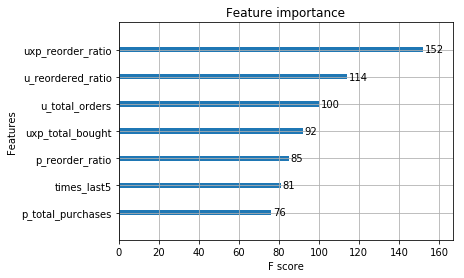

In [54]:
# TRAIN FULL 
###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost as xgb

##########################################
## SPLIT DF TO: X_train, y_train (axis=1)
##########################################
X_train, y_train = data_train.drop('reordered', axis=1), data_train.reordered

########################################
## SET BOOSTER'S PARAMETERS
########################################
parameters = {'eval_metric':'logloss', 
              'max_depth': 5, 
              'colsample_bytree': 0.4,
              'subsample': 0.75,
              'gpu_id': 0,
              'tree_method':'gpu_hist'
             }

########################################
## INSTANTIATE XGBClassifier()
########################################
xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

########################################
## TRAIN MODEL
########################################
model = xgbc.fit(X_train, y_train)

##################################
# FEATURE IMPORTANCE - GRAPHICAL
##################################
xgb.plot_importance(model)

## 4.2 Fine-tune your model

Most algorithms have their own parameters that we need to declare. With method .get_params() we can retrieve the parameters of our fitting model

In [55]:
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'silent': True,
 'subsample': 1,
 'parameters': {'eval_metric': 'logloss',
  'max_depth': '5',
  'colsample_bytree': '0.4',
  'subsample': '0.75'},
 'num_boost_round': 10,
 'verbosity': 0}

These parameters do not necessarily create the best fitting model (in terms of prediction score). The method .GridSearchCV( ) can make several trials to define the best parameters for our fitting model. 

In [56]:
###########################
## DISABLE WARNINGS
###########################
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

####################################
## SET BOOSTER'S RANGE OF PARAMETERS
# IMPORTANT NOTICE: Fine-tuning an XGBoost model may be a computational prohibitive process with a regular computer or a Kaggle kernel. 
# Be cautious what parameters you enter in paramiGrid section.
# More paremeters means that GridSearch will create and evaluate more models.
####################################    
paramGrid = {"max_depth":[5,10],
            "colsample_bytree":[0.3,0.4]}  

########################################
## INSTANTIATE XGBClassifier()
########################################
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10, gpu_id=0, tree_method = 'gpu_hist')

##############################################
## DEFINE HOW TO TRAIN THE DIFFERENT MODELS
#############################################
gridsearch = GridSearchCV(xgbc, paramGrid, cv=3, verbose=2, n_jobs=1)

################################################################
## TRAIN THE MODELS
### - with the combinations of different parameters
### - here is where GridSearch will be exeucuted
#################################################################
model = gridsearch.fit(X_train, y_train)

##################################
## OUTPUT(S)
##################################
# Print the best parameters
print("The best parameters are: /n",  gridsearch.best_params_)

# Store the model for prediction (chapter 5)
model = gridsearch.best_estimator_

# Delete X_train , y_train
del [X_train, y_train]


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] colsample_bytree=0.3, max_depth=5 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ colsample_bytree=0.3, max_depth=5, total=  31.7s
[CV] colsample_bytree=0.3, max_depth=5 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.5s remaining:    0.0s


[CV] ................ colsample_bytree=0.3, max_depth=5, total=  34.8s
[CV] colsample_bytree=0.3, max_depth=5 ...............................
[CV] ................ colsample_bytree=0.3, max_depth=5, total=  31.1s
[CV] colsample_bytree=0.3, max_depth=10 ..............................
[CV] ............... colsample_bytree=0.3, max_depth=10, total=  51.2s
[CV] colsample_bytree=0.3, max_depth=10 ..............................
[CV] ............... colsample_bytree=0.3, max_depth=10, total=  51.1s
[CV] colsample_bytree=0.3, max_depth=10 ..............................
[CV] ............... colsample_bytree=0.3, max_depth=10, total=  51.3s
[CV] colsample_bytree=0.4, max_depth=5 ...............................
[CV] ................ colsample_bytree=0.4, max_depth=5, total=  31.2s
[CV] colsample_bytree=0.4, max_depth=5 ...............................
[CV] ................ colsample_bytree=0.4, max_depth=5, total=  31.6s
[CV] colsample_bytree=0.4, max_depth=5 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  9.5min finished


The best parameters are: /n {'colsample_bytree': 0.3, 'max_depth': 5}


The model has now the new parameters from GridSearchCV:

In [57]:
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.3,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1,
 'eval_metric': 'logloss',
 'num_boost_round': 10}

# 5. Apply predictive model (predict)
The model that we have created is stored in the **model** object.
At this step we predict the values for the test data and we store them in a new column in the same DataFrame.

For better results, we set a custom threshold to 0.21. The best custom threshold can be found through a grid search.

In [58]:
'''
# Predict values for test data with our model from chapter 5 - the results are saved as a Python array
test_pred = model.predict(data_test).astype(int)
test_pred[0:20] #display the first 20 predictions of the numpy array
'''

'\n# Predict values for test data with our model from chapter 5 - the results are saved as a Python array\ntest_pred = model.predict(data_test).astype(int)\ntest_pred[0:20] #display the first 20 predictions of the numpy array\n'

In [59]:
## OR set a custom threshold (in this problem, 0.21 yields the best prediction)
test_pred = (model.predict_proba(data_test)[:,1] >= 0.21).astype(int)
test_pred[0:20] #display the first 20 predictions of the numpy array

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [60]:
#Save the prediction (saved in a numpy array) on a new column in the data_test DF
data_test['prediction'] = test_pred
data_test.head(10)

uxp_total_bought  ...  prediction
user_id product_id                    ...            
22      2452                       2  ...           0
        4217                       1  ...           0
        4421                       1  ...           0
        5212                       1  ...           0
        5450                       1  ...           0
        7088                       1  ...           0
        7948                       2  ...           0
        8518                       2  ...           0
        13176                      4  ...           1
        14678                      1  ...           0

[10 rows x 8 columns]

In [61]:
# Reset the index
final = data_test.reset_index()
# Keep only the required columns to create our submission file (for chapter 6)
final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

,product_id,user_id,prediction
0,2452,22,0
1,4217,22,0
2,4421,22,0
3,5212,22,0
4,5450,22,0


# 6. Creation of Submission File
To submit our prediction to Instacart competition we have to get for each user_id (test users) their last order_id. The final submission file should have the test order numbers and the products that we predict that are going to be bought.

To create this file we retrieve from orders DataFrame all the test orders with their matching user_id:

In [62]:
orders_test = orders.loc[orders.eval_set=='test',("user_id", "order_id") ]
orders_test.head()

,user_id,order_id
272,22,139655
588,40,2431024
1148,75,1970262
1445,94,622677
1875,129,688716


We merge it with our predictions (from chapter 5) using a left join:
<img src="https://i.imgur.com/KJubu0v.jpg" width="400">

In [63]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,2452,22,0,139655
1,4217,22,0,139655
2,4421,22,0,139655
3,5212,22,0,139655
4,5450,22,0,139655


And we move on with two final manipulations:
- remove any undesired column (in our case user_id)

In [64]:
#remove user_id column
final = final.drop('user_id', axis=1)

- set product_id column as integer (mandatory action to proceed to the next step)

In [65]:
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
del orders
del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,2452,0,139655
1,4217,0,139655
2,4421,0,139655
3,5212,0,139655
4,5450,0,139655


For our submission file we initiate an empty dictionary. In this dictionary we will place as index the order_id and as values all the products that the order will have. If none product will be purchased, we have explicitly to place the string "None". This syntax follows the submission's file standards defined by the competition.

In [66]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

#We now check how the dictionary were populated (open hidden output)
d

{139655: '13176 21903 22935 24964 27845 32655',
 2431024: '5322 5450 5699 6975 13176 17044 22035 24799 25246 27555 29926 34217 39928',
 1970262: '4274 4562 11520 12872 13176 21267 21567 21903 22451 24964 27104 27105 28058 29071 30489 44683 48364',
 622677: '2192',
 688716: '3721 5077 13176 36929 47209 47626',
 1920100: '2748 9444 19173 21903 22582 22908 30391 34458 35221 37687 41658 46969 47209 49235',
 2088686: '1516 3583 5380 5479 9390 23236 26128 27531 29837 30489 31553 39877 39928 40311 42265 46802 47626',
 2305779: '12341 22935 22938 42043 48174',
 2193705: '4149 6087 6184 8048 12341 21903 29223 30827 38768 39275 40120 40742 48762',
 1185710: '9839 14715 15995 19508 21137 21267 21903 22935 24852 24964 27548 27845 28204 30391 35221 38689 45633 49236',
 442242: '3957 7521 25718',
 1918388: '5134 14084 25931 27104 33120 39639 42265 42585',
 1990335: '10749 21663 43598 43961',
 668032: '6347',
 476412: '5450 24852 32153',
 2151106: '4776 13176 16541 21137 28227 43352 47141',
 836275: 

We convert the dictionary to a DataFrame and prepare it to extact it into a .csv file

In [67]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,139655,13176 21903 22935 24964 27845 32655
1,2431024,5322 5450 5699 6975 13176 17044 22035 24799 25...
2,1970262,4274 4562 11520 12872 13176 21267 21567 21903 ...
3,622677,2192
4,688716,3721 5077 13176 36929 47209 47626


**The submission file should have 75.000 predictions to be submitted in the competition**

In [68]:
#Check if sub file has 75000 predictions
sub.shape[0]
print(sub.shape[0]==75000)

False


The DataFrame can now be converted to .csv file. Pandas can export a DataFrame to a .csv file with the .to_csv( ) function.

In [69]:
sub.to_csv('sub.csv', index=False)

# 7. Get F1 Score

Before you are ready to submit your prediction to the competion, **ensure that**:
- **You have used all of the offered data and not the 10% that was defined as an optional step on section 1.2**

To submit your prediction and get the F1 score you have to:
1. Commit this notebook and wait for the results 
2. Go to view mode (where you see your notebook but you can't edit it)
3. Click on the data section from your left panel
4. Find the sub.csv (on outputs), below the section with the data from Instacart
5. Click on "Submit to competition" button

Regarding step 1:
>This step might take long. If it exceeds 20-30 minutes it would be wise to check your code again. Kaggle won't inform you during commit if the notebook has:
- syntax errors
- if it exceeds 16 GB RAM
- if it takes an algorirthms too much to train or predict

>Any new commit:
- can't take more than 9 hours
- doesn't stop if it exceeds the 16 GB RAM - you will just receive an error of unsuccesful commit after 9 hours